In [2]:
# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
import os 
from datetime import datetime


%matplotlib inline


In [3]:
# Extract results arrays

# Define the path to the parent directory
parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output'

## 1.1. Analysis of error of distortion (corr, hes, ssmi) of SAR forecast

In [4]:
# of quality parameters from output folder
# Initialize lists to store parameters and timestamps
rpm_list = []
hpm_list = []
ssim_list = []
lon2pm_list = []
lat2pm_list = []
timestamps = []

gpi1_list = []
gpi2_list = []

# Iterate through subdirectories (folders for each pair)
for subdir in os.listdir(parent_dir):
    sub_dir_path = os.path.join(parent_dir, subdir)
    
    # Check if the 'sar_drift_forecast_quality.npz' file exists
    npz_file_path = os.path.join(sub_dir_path, 'sar_distort_error_data', 'sar_distort_error_data.npz')
    if os.path.exists(npz_file_path):
        # Load the contents of the .npz file
        npz_data = np.load(npz_file_path)
        
        # Extract and append parameters to their respective lists
        rpm_list.append(npz_data['rpm'])
        hpm_list.append(npz_data['hpm'])
        ssim_list.append(npz_data['ssim'])
        lon2pm_list.append(npz_data['lon2pm'])
        lat2pm_list.append(npz_data['lat2pm'])
        gpi1_list.append(npz_data['gpi1'])
        gpi2_list.append(npz_data['gpi2'])
        
        # Extract and append the timestamps from folder names
        timestamps.append(subdir)

In [5]:
# Initialize lists to store mean values for each parameter
rpm_mean_values = []
hpm_mean_values = []
ssim_mean_values = []

# Iterate through the pairs and calculate mean values
for i in range(len(timestamps)):
    # Calculate mean values for each parameter where gpi2 is True
    rpm_mean = rpm_list[i][gpi2_list[i]].mean()
    hpm_mean = hpm_list[i][gpi2_list[i]].mean()
    ssim_mean = ssim_list[i][gpi2_list[i]].mean()
    
    # Append mean values to respective lists
    rpm_mean_values.append(rpm_mean)
    hpm_mean_values.append(hpm_mean)
    ssim_mean_values.append(ssim_mean)

# Now, rpm_mean_values, hpm_mean_values, and ssim_mean_values contain the mean values for each pair


In [6]:
# Assuming you have the lists rpm_list, hpm_list, ssim_list, and timestamps

# Initialize lists to store mean, min, and max values for each parameter
rpm_mean_values = []
rpm_min_values = []
rpm_max_values = []

hpm_mean_values = []
hpm_min_values = []
hpm_max_values = []

ssim_mean_values = []
ssim_min_values = []
ssim_max_values = []

# Iterate through the pairs and calculate statistics
for i in range(len(timestamps)):
    # Calculate mean, min, and max values for RPM where gpi2 is True
    rpm_data = rpm_list[i][gpi2_list[i]]
    rpm_mean = round(np.nanmean(rpm_data), 2)
    rpm_min = round(np.nanmin(rpm_data), 2)
    rpm_max = round(np.nanmax(rpm_data), 2)
    
    # Append values to respective lists
    rpm_mean_values.append(rpm_mean)
    rpm_min_values.append(rpm_min)
    rpm_max_values.append(rpm_max)

    # Calculate mean, min, and max values for HPM where gpi2 is True
    hpm_data = hpm_list[i][gpi2_list[i]]
    hpm_mean = round(np.nanmean(hpm_data), 2)
    hpm_min = round(np.nanmin(hpm_data), 2)
    hpm_max = round(np.nanmax(hpm_data), 2)
    
    # Append values to respective lists
    hpm_mean_values.append(hpm_mean)
    hpm_min_values.append(hpm_min)
    hpm_max_values.append(hpm_max)

    # Calculate mean, min, and max values for SSIM where gpi2 is True
    ssim_data = ssim_list[i][gpi2_list[i]]
    ssim_mean = round(np.nanmean(ssim_data), 2)
    ssim_min = round(np.nanmin(ssim_data), 2)
    ssim_max = round(np.nanmax(ssim_data), 2)
    
    # Append values to respective lists
    ssim_mean_values.append(ssim_mean)
    ssim_min_values.append(ssim_min)
    ssim_max_values.append(ssim_max)

    # Print the calculated statistics for the current pair
    print(f"Pair {i + 1}:")
    print(f"RPM Mean: {rpm_mean}, Min: {rpm_min}, Max: {rpm_max}")
    print(f"HPM Mean: {hpm_mean}, Min: {hpm_min}, Max: {hpm_max}")
    print(f"SSIM Mean: {ssim_mean}, Min: {ssim_min}, Max: {ssim_max}")
    print("-" * 20)

# Now, rpm_mean_values, rpm_min_values, rpm_max_values, hpm_mean_values, hpm_min_values, hpm_max_values,
# ssim_mean_values, ssim_min_values, and ssim_max_values contain the calculated statistics for each parameter
# where gpi2 is True


Pair 1:
RPM Mean: 0.56, Min: 0.2, Max: 0.92
HPM Mean: 15.29, Min: -0.24, Max: 31.92
SSIM Mean: 0.4, Min: 0.01, Max: 0.89
--------------------
Pair 2:
RPM Mean: 0.58, Min: 0.21, Max: 0.9
HPM Mean: 13.93, Min: -0.49, Max: 32.88
SSIM Mean: 0.37, Min: 0.01, Max: 0.77
--------------------
Pair 3:
RPM Mean: 0.49, Min: 0.2, Max: 0.88
HPM Mean: 12.75, Min: -0.94, Max: 30.31
SSIM Mean: 0.34, Min: 0.03, Max: 0.78
--------------------
Pair 4:
RPM Mean: 0.47, Min: 0.17, Max: 1.0
HPM Mean: 12.23, Min: -0.33, Max: 29.48
SSIM Mean: 0.33, Min: 0.0, Max: 0.79
--------------------
Pair 5:
RPM Mean: 0.45, Min: 0.19, Max: 0.97
HPM Mean: 11.87, Min: 0.12, Max: 29.69
SSIM Mean: 0.32, Min: 0.01, Max: 0.97
--------------------
Pair 6:
RPM Mean: 0.49, Min: 0.19, Max: 0.85
HPM Mean: 14.15, Min: 0.62, Max: 27.68
SSIM Mean: 0.36, Min: 0.08, Max: 0.67
--------------------
Pair 7:
RPM Mean: 0.51, Min: 0.17, Max: 0.84
HPM Mean: 15.08, Min: -0.26, Max: 28.93
SSIM Mean: 0.38, Min: 0.0, Max: 0.72
--------------------
P

In [7]:
rpm_mean_values, hpm_mean_values, ssim_mean_values

([0.56, 0.58, 0.49, 0.47, 0.45, 0.49, 0.51, 0.52, 0.56],
 [15.29, 13.93, 12.75, 12.23, 11.87, 14.15, 15.08, 12.38, 13.14],
 [0.4, 0.37, 0.34, 0.33, 0.32, 0.36, 0.38, 0.32, 0.35])

In [8]:
sar_rpm_mean, sar_hpm_mean, sar_ssim_mean = rpm_mean_values, hpm_mean_values, ssim_mean_values

In [9]:
print(timestamps)
date_labels = []
for ts in timestamps:
    # Split the string into the start and end dates
    start_date_str, end_date_str = ts.split('_')
    # Convert to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y%m%dT%H%M%S")
    end_date = datetime.strptime(end_date_str, "%Y%m%dT%H%M%S")
    # Format the dates as "DD-DD.MM.YYYY"
    date_label = f"{start_date.day:02d}-{end_date.day:02d}.{start_date.month:02d}.{start_date.year}"
    date_labels.append(date_label)
date_labels

['20221120T080155_20221122T074535', '20221207T081027_20221209T075358', '20221226T080153_20221228T074533', '20230107T080152_20230109T074532', '20230119T080151_20230121T074532', '20230210T081814_20230212T080151', '20230212T080151_20230214T074531', '20230320T080151_20230322T074531', '20230327T075355_20230329T073729']


['20-22.11.2022',
 '07-09.12.2022',
 '26-28.12.2022',
 '07-09.01.2023',
 '19-21.01.2023',
 '10-12.02.2023',
 '12-14.02.2023',
 '20-22.03.2023',
 '27-29.03.2023']

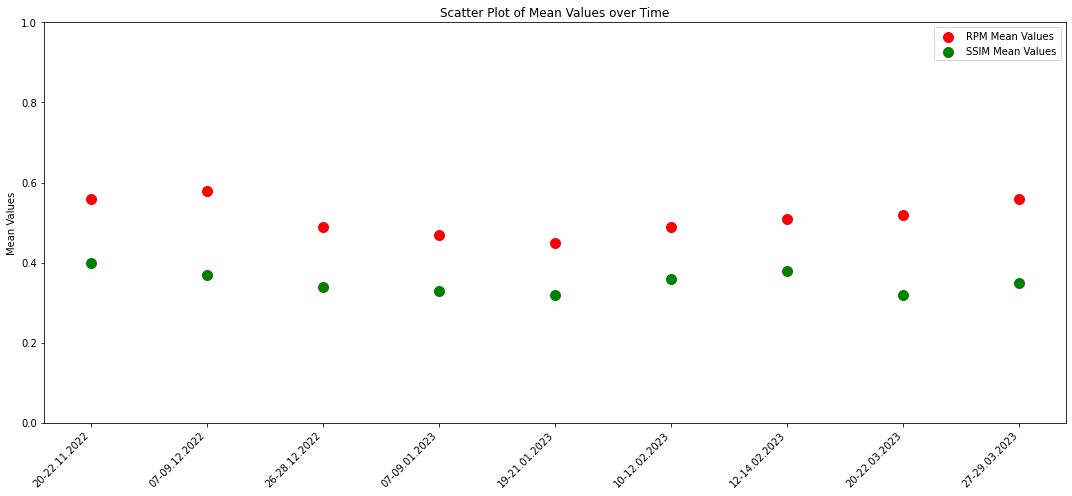

In [10]:
# Create a scatter plot

plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean, color='green',s=100, label='SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

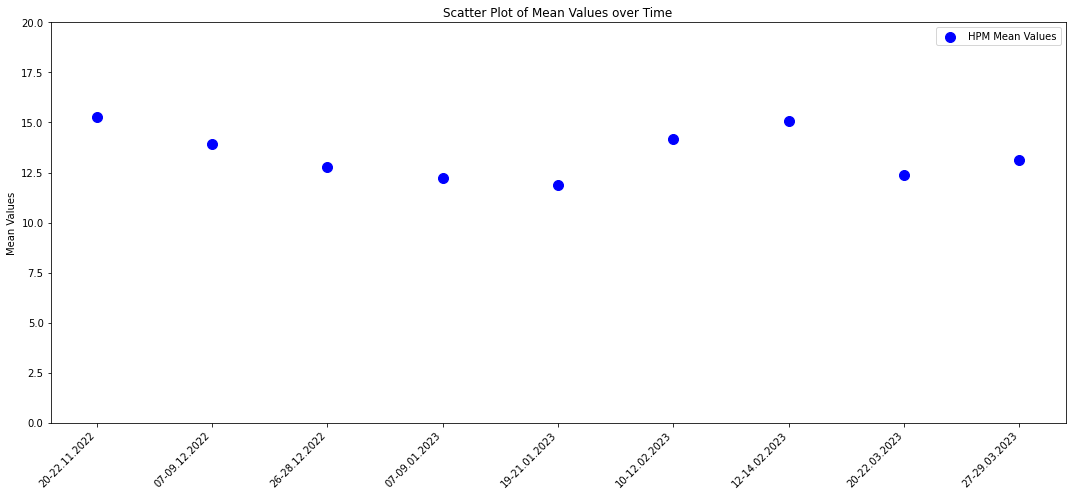

In [11]:
# Create a scatter plot
plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_hpm_mean, color='blue', s=100, label='HPM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 20])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

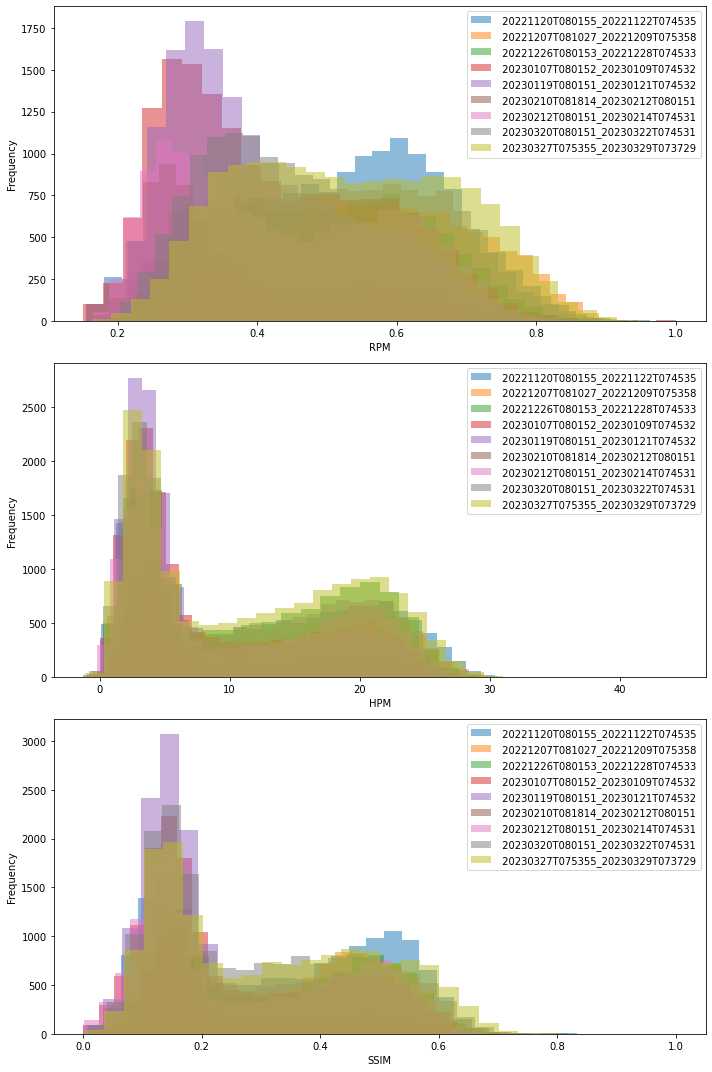

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the lists upm_list, vpm_list, apm_list, rpm_list, hpm_list, ssim_list, and timestamps

# Initialize histograms for each parameter
rpm_histogram = []
hpm_histogram = []
ssim_histogram = []

# Create a list of unique timestamps
unique_timestamps = list(sorted(set(timestamps)))  # Sort the unique timestamps

# Create subplots for histograms
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Iterate through timestamps and plot histograms with different colors
for i, timestamp in enumerate(unique_timestamps):
    # Filter data for the current timestamp
    rpm_data = [rpm for j, rpm in enumerate(rpm_list) if timestamps[j] == timestamp]
    hpm_data = [hpm for j, hpm in enumerate(hpm_list) if timestamps[j] == timestamp]
    ssim_data = [ssim for j, ssim in enumerate(ssim_list) if timestamps[j] == timestamp]
    
    # Flatten the data for histograms
    rpm_data_flat = np.concatenate(rpm_data)
    hpm_data_flat = np.concatenate(hpm_data)
    ssim_data_flat = np.concatenate(ssim_data)
    
    # Remove NaN values from the data
    rpm_data_flat = rpm_data_flat[~np.isnan(rpm_data_flat)]
    hpm_data_flat = hpm_data_flat[~np.isnan(hpm_data_flat)]
    ssim_data_flat = ssim_data_flat[~np.isnan(ssim_data_flat)]
    
    # Create histograms
    ax1.hist(rpm_data_flat, bins=30, alpha=0.5, label=f' {timestamp}')
    ax2.hist(hpm_data_flat, bins=30, alpha=0.5, label=f' {timestamp}')
    ax3.hist(ssim_data_flat, bins=30, alpha=0.5, label=f' {timestamp}')

# Add labels and legends
ax1.set_xlabel('RPM')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('HPM')
ax2.set_ylabel('Frequency')
ax2.legend()
ax3.set_xlabel('SSIM')
ax3.set_ylabel('Frequency')
ax3.legend()

# Show the histograms
plt.tight_layout()
plt.show()


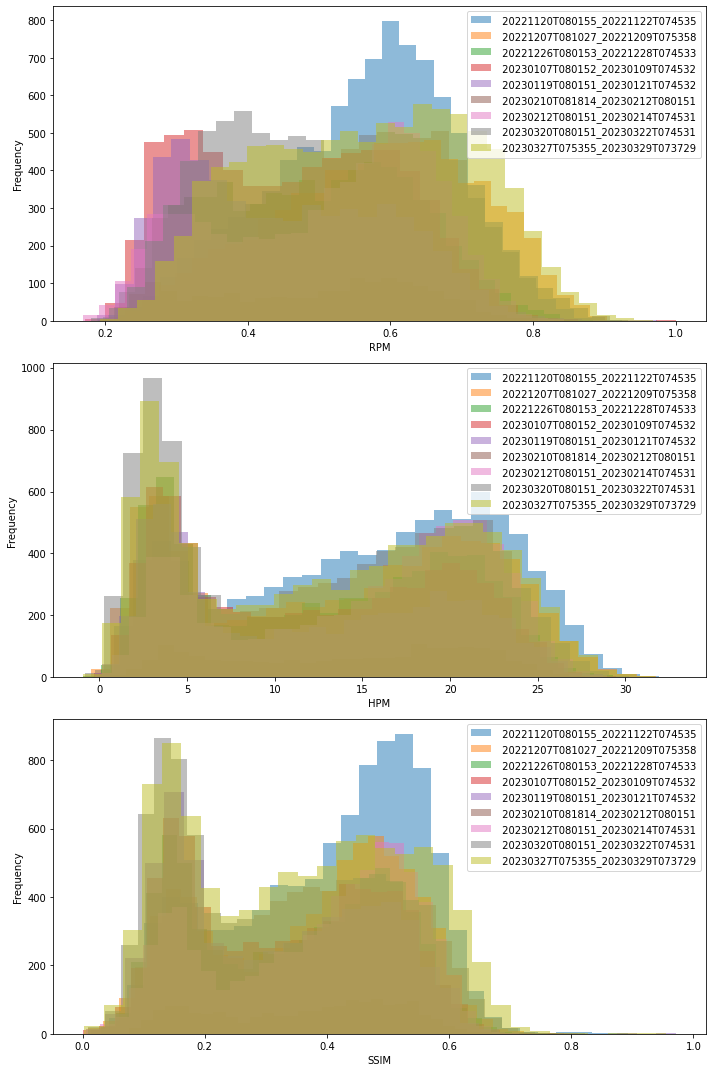

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the lists upm_list, vpm_list, apm_list, rpm_list, hpm_list, ssim_list, and timestamps

# Initialize histograms for each parameter
rpm_histogram = []
hpm_histogram = []
ssim_histogram = []

# Create a list of unique timestamps
unique_timestamps = list(sorted(set(timestamps)))  # Sort the unique timestamps

# Create subplots for histograms
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Iterate through timestamps and plot histograms with different colors
for i, timestamp in enumerate(unique_timestamps):
    # Filter data for the current timestamp
    rpm_data = [rpm for j, rpm in enumerate(rpm_list) if timestamps[j] == timestamp]
    hpm_data = [hpm for j, hpm in enumerate(hpm_list) if timestamps[j] == timestamp]
    ssim_data = [ssim for j, ssim in enumerate(ssim_list) if timestamps[j] == timestamp]
    
    # Flatten the data for histograms
    rpm_data_flat = np.concatenate(rpm_data)
    hpm_data_flat = np.concatenate(hpm_data)
    ssim_data_flat = np.concatenate(ssim_data)
    
    # Create histograms
    ax1.hist(rpm_data_flat[gpi2_list[i]], bins=30, alpha=0.5, label=f' {timestamp}')
    ax2.hist(hpm_data_flat[gpi2_list[i]], bins=30, alpha=0.5, label=f' {timestamp}')
    ax3.hist(ssim_data_flat[gpi2_list[i]], bins=30, alpha=0.5, label=f' {timestamp}')
    

# Add labels and legends
ax1.set_xlabel('RPM')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('HPM')
ax2.set_ylabel('Frequency')
ax2.legend()
ax3.set_xlabel('SSIM')
ax3.set_ylabel('Frequency')
ax3.legend()

# Show the histograms
plt.tight_layout()
plt.show()


## 1.2 Analysis of error of distortion (corr, hes, ssmi) of Model forecast

In [67]:
# of quality parameters from output folder
# Initialize lists to store parameters and timestamps
rpm_list = []
hpm_list = []
ssim_list = []
lon2pm_list = []
lat2pm_list = []
timestamps = []

gpi1_list = []
gpi2_list = []

# Iterate through subdirectories (folders for each pair)
for subdir in os.listdir(parent_dir):
    sub_dir_path = os.path.join(parent_dir, subdir)
    
    # Check if the 'sar_drift_forecast_quality.npz' file exists
    npz_file_path = os.path.join(sub_dir_path, 'model_distort_error_data', 'model_distort_error_data.npz')
    if os.path.exists(npz_file_path):
        # Load the contents of the .npz file
        npz_data = np.load(npz_file_path)
        
        # Extract and append parameters to their respective lists
        rpm_list.append(npz_data['rpm'])
        hpm_list.append(npz_data['hpm'])
        ssim_list.append(npz_data['ssim'])
        lon2pm_list.append(npz_data['lon2pm'])
        lat2pm_list.append(npz_data['lat2pm'])
        gpi1_list.append(npz_data['gpi1'])
        gpi2_list.append(npz_data['gpi2'])
        
        # Extract and append the timestamps from folder names
        timestamps.append(subdir)

In [68]:
# Initialize lists to store mean values for each parameter
rpm_mean_values = []
hpm_mean_values = []
ssim_mean_values = []

# Iterate through the pairs and calculate mean values
for i in range(len(timestamps)):
    # Calculate mean values for each parameter where gpi2 is True
    rpm_mean = rpm_list[i][gpi2_list[i]].mean()
    hpm_mean = hpm_list[i][gpi2_list[i]].mean()
    ssim_mean = ssim_list[i][gpi2_list[i]].mean()
    
    # Append mean values to respective lists
    rpm_mean_values.append(rpm_mean)
    hpm_mean_values.append(hpm_mean)
    ssim_mean_values.append(ssim_mean)

# Now, rpm_mean_values, hpm_mean_values, and ssim_mean_values contain the mean values for each pair


In [69]:
# Assuming you have the lists rpm_list, hpm_list, ssim_list, and timestamps

# Initialize lists to store mean, min, and max values for each parameter
rpm_mean_values = []
rpm_min_values = []
rpm_max_values = []

hpm_mean_values = []
hpm_min_values = []
hpm_max_values = []

ssim_mean_values = []
ssim_min_values = []
ssim_max_values = []

# Iterate through the pairs and calculate statistics
for i in range(len(timestamps)):
    # Calculate mean, min, and max values for RPM where gpi2 is True
    rpm_data = rpm_list[i][gpi2_list[i]]
    rpm_mean = round(np.nanmean(rpm_data), 2)
    rpm_min = round(np.nanmin(rpm_data), 2)
    rpm_max = round(np.nanmax(rpm_data), 2)
    
    # Append values to respective lists
    rpm_mean_values.append(rpm_mean)
    rpm_min_values.append(rpm_min)
    rpm_max_values.append(rpm_max)

    # Calculate mean, min, and max values for HPM where gpi2 is True
    hpm_data = hpm_list[i][gpi2_list[i]]
    hpm_mean = round(np.nanmean(hpm_data), 2)
    hpm_min = round(np.nanmin(hpm_data), 2)
    hpm_max = round(np.nanmax(hpm_data), 2)
    
    # Append values to respective lists
    hpm_mean_values.append(hpm_mean)
    hpm_min_values.append(hpm_min)
    hpm_max_values.append(hpm_max)

    # Calculate mean, min, and max values for SSIM where gpi2 is True
    ssim_data = ssim_list[i][gpi2_list[i]]
    ssim_mean = round(np.nanmean(ssim_data), 2)
    ssim_min = round(np.nanmin(ssim_data), 2)
    ssim_max = round(np.nanmax(ssim_data), 2)
    
    # Append values to respective lists
    ssim_mean_values.append(ssim_mean)
    ssim_min_values.append(ssim_min)
    ssim_max_values.append(ssim_max)

    # Print the calculated statistics for the current pair
    print(f"Pair {i + 1}:")
    print(f"RPM Mean: {rpm_mean}, Min: {rpm_min}, Max: {rpm_max}")
    print(f"HPM Mean: {hpm_mean}, Min: {hpm_min}, Max: {hpm_max}")
    print(f"SSIM Mean: {ssim_mean}, Min: {ssim_min}, Max: {ssim_max}")
    print("-" * 20)

# Now, rpm_mean_values, rpm_min_values, rpm_max_values, hpm_mean_values, hpm_min_values, hpm_max_values,
# ssim_mean_values, ssim_min_values, and ssim_max_values contain the calculated statistics for each parameter
# where gpi2 is True


Pair 1:
RPM Mean: 0.45, Min: 0.2, Max: 0.93
HPM Mean: 8.6, Min: -0.58, Max: 29.88
SSIM Mean: 0.27, Min: 0.01, Max: 0.97
--------------------
Pair 2:
RPM Mean: 0.46, Min: 0.2, Max: 0.91
HPM Mean: 6.33, Min: -0.97, Max: 27.37
SSIM Mean: 0.22, Min: 0.01, Max: 0.8
--------------------
Pair 3:
RPM Mean: 0.4, Min: 0.0, Max: 0.9
HPM Mean: 7.25, Min: -0.59, Max: 26.37
SSIM Mean: 0.24, Min: 0.0, Max: 0.7
--------------------
Pair 4:
RPM Mean: 0.43, Min: 0.17, Max: 0.85
HPM Mean: 10.15, Min: -0.12, Max: 26.79
SSIM Mean: 0.3, Min: 0.0, Max: 0.67
--------------------
Pair 5:
RPM Mean: 0.38, Min: 0.0, Max: 0.82
HPM Mean: 7.94, Min: -0.33, Max: 97.42
SSIM Mean: 0.24, Min: 0.0, Max: 0.85
--------------------
Pair 6:
RPM Mean: 0.41, Min: 0.19, Max: 0.74
HPM Mean: 9.46, Min: 0.24, Max: 22.49
SSIM Mean: 0.28, Min: 0.01, Max: 0.62
--------------------
Pair 7:
RPM Mean: 0.45, Min: 0.17, Max: 0.84
HPM Mean: 11.75, Min: 0.18, Max: 32.73
SSIM Mean: 0.33, Min: 0.01, Max: 0.9
--------------------
Pair 8:
RPM M

In [70]:
rpm_mean_values, hpm_mean_values, ssim_mean_values

([0.45, 0.46, 0.4, 0.43, 0.38, 0.41, 0.45, 0.49, 0.52],
 [8.6, 6.33, 7.25, 10.15, 7.94, 9.46, 11.75, 10.37, 10.02],
 [0.27, 0.22, 0.24, 0.3, 0.24, 0.28, 0.33, 0.3, 0.31])

In [71]:
mod_rpm_mean, mod_hpm_mean, mod_ssim_mean = rpm_mean_values, hpm_mean_values, ssim_mean_values

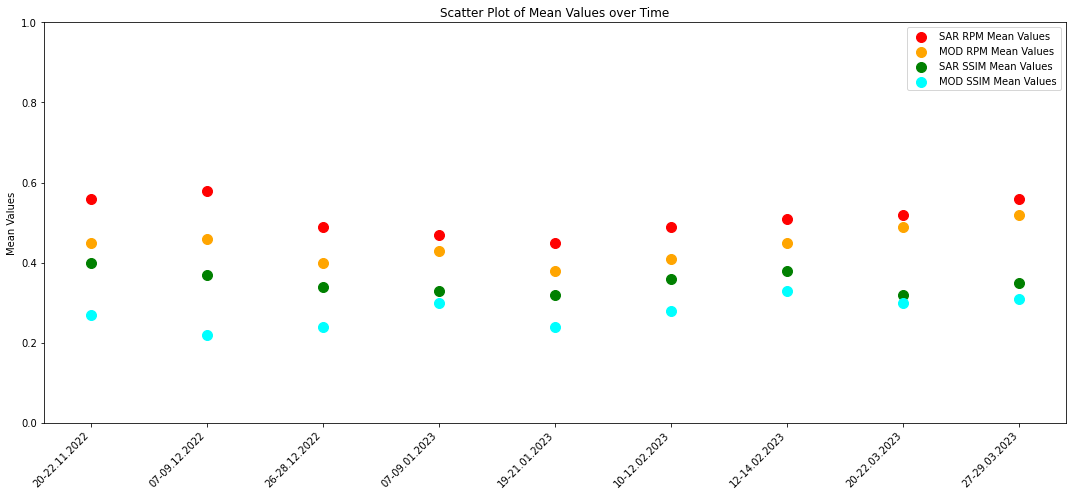

In [72]:
# Create a scatter plot

plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
plt.scatter(date_labels, mod_rpm_mean, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean, color='green',s=100, label='SAR SSIM Mean Values')
plt.scatter(date_labels, mod_ssim_mean, color='cyan',s=100, label='MOD SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [75]:
rpm_dif = sar_rpm_mean-mod_rpm_mean

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [74]:
# Create a scatter plot

plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_rpm_mean-mod_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
#plt.scatter(date_labels, mod_rpm_mean-, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean-mod_ssim_mean, color='green',s=100, label='SAR SSIM Mean Values')
#plt.scatter(date_labels, mod_ssim_mean, color='cyan',s=100, label='MOD SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

TypeError: unsupported operand type(s) for -: 'list' and 'list'

<Figure size 1080x504 with 0 Axes>

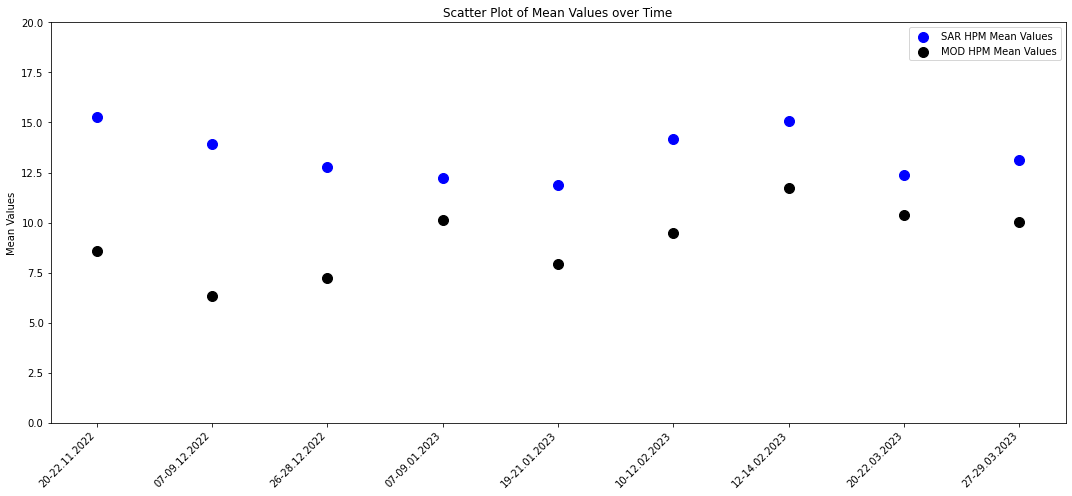

In [73]:
# Create a scatter plot
plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_hpm_mean, color='blue', s=100, label='SAR HPM Mean Values')
plt.scatter(date_labels, mod_hpm_mean, color='black', s=100, label='MOD HPM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 20])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

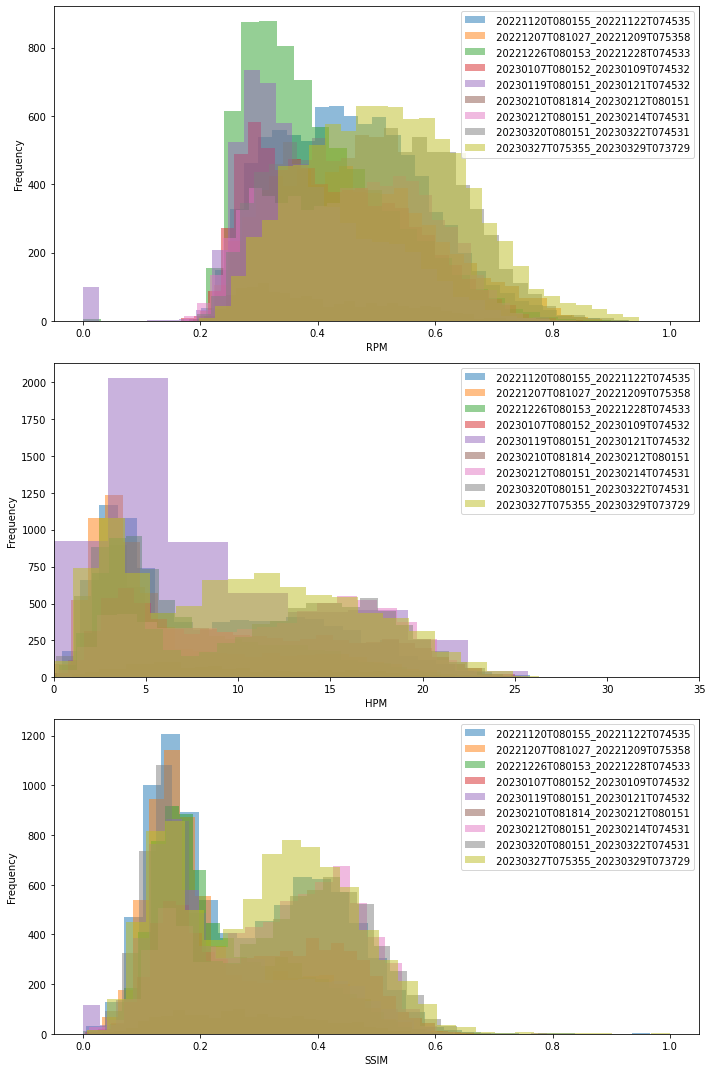

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the lists upm_list, vpm_list, apm_list, rpm_list, hpm_list, ssim_list, and timestamps

# Initialize histograms for each parameter
rpm_histogram = []
hpm_histogram = []
ssim_histogram = []

# Create a list of unique timestamps
unique_timestamps = list(sorted(set(timestamps)))  # Sort the unique timestamps

# Create subplots for histograms
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Iterate through timestamps and plot histograms with different colors
for i, timestamp in enumerate(unique_timestamps):
    # Filter data for the current timestamp
    rpm_data = [rpm for j, rpm in enumerate(rpm_list) if timestamps[j] == timestamp]
    hpm_data = [hpm for j, hpm in enumerate(hpm_list) if timestamps[j] == timestamp]
    ssim_data = [ssim for j, ssim in enumerate(ssim_list) if timestamps[j] == timestamp]
    
    # Flatten the data for histograms
    rpm_data_flat = np.concatenate(rpm_data)
    hpm_data_flat = np.concatenate(hpm_data)
    ssim_data_flat = np.concatenate(ssim_data)
    
    # Create histograms
    ax1.hist(rpm_data_flat[gpi2_list[i]], bins=30, alpha=0.5, label=f' {timestamp}')
    ax2.hist(hpm_data_flat[gpi2_list[i]], bins=30, alpha=0.5, label=f' {timestamp}')
    ax3.hist(ssim_data_flat[gpi2_list[i]], bins=30, alpha=0.5, label=f' {timestamp}')
    

# Add labels and legends
ax1.set_xlabel('RPM')
ax1.set_ylabel('Frequency')
ax1.legend()
# Setting the x-axis limit to 40
ax2.set_xlim([0, 35])
ax2.set_xlabel('HPM')
ax2.set_ylabel('Frequency')
ax2.legend()
ax3.set_xlabel('SSIM')
ax3.set_ylabel('Frequency')
ax3.legend()

# Show the histograms
plt.tight_layout()
plt.show()


## 2. Analysis of error of distortion (corr, hes, ssmi) of model forecast

## 3. SAR and model drift comparison

### Extracting sar and model displacements

In [48]:
# of drift vectors and gpi which was used for filtering of drift data
u_sar_list = []
v_sar_list = []
u_b_list = []
v_b_list = []

# Iterate through subdirectories (folders for each pair)
for subdir in os.listdir(parent_dir):
    sub_dir_path = os.path.join(parent_dir, subdir)
    
    # Check if the 'sar_drift_forecast_quality.npz' file exists
    npz_sar_file_path = os.path.join(sub_dir_path, 'sar_drift_output', 'sar_drift_output.npz')
    npz_mod_file_path = os.path.join(sub_dir_path, 'mod_drift_output', 'mod_drift_output.npz')
    
    if os.path.exists(npz_sar_file_path):
        # Load the contents of the .npz file
        npz_sar_data = np.load(npz_sar_file_path)
        
        # Extract and append parameters to their respective lists
        u_sar_list.append(npz_sar_data['upm'])
        v_sar_list.append(npz_sar_data['vpm'])
        #gpi1_list.append(npz_data['gpi1'])
        #gpi2_list.append(npz_data['gpi2'])
        
    if os.path.exists(npz_mod_file_path):
        # Load the contents of the .npz file
        npz_mod_data = np.load(npz_mod_file_path)
        
        # Extract and append parameters to their respective lists
        u_b_list.append(npz_mod_data['model_u'])
        v_b_list.append(npz_mod_data['model_v'])


In [50]:
# Function to replace 'inf' values with 'nan' in a list of arrays
def replace_inf_with_nan(arrays):
    return [np.where(np.isinf(array), np.nan, array) for array in arrays]

# Replace 'inf' with 'nan' in each list
u_sar_list = replace_inf_with_nan(u_sar_list)
v_sar_list = replace_inf_with_nan(v_sar_list)


In [51]:
# Replace inf with NaN before calculating the mean
u_sar_list = np.where(np.isinf(u_sar_list), np.nan, u_sar_list)
v_sar_list = np.where(np.isinf(v_sar_list), np.nan, v_sar_list)


### Model total displacement

### Comaprison

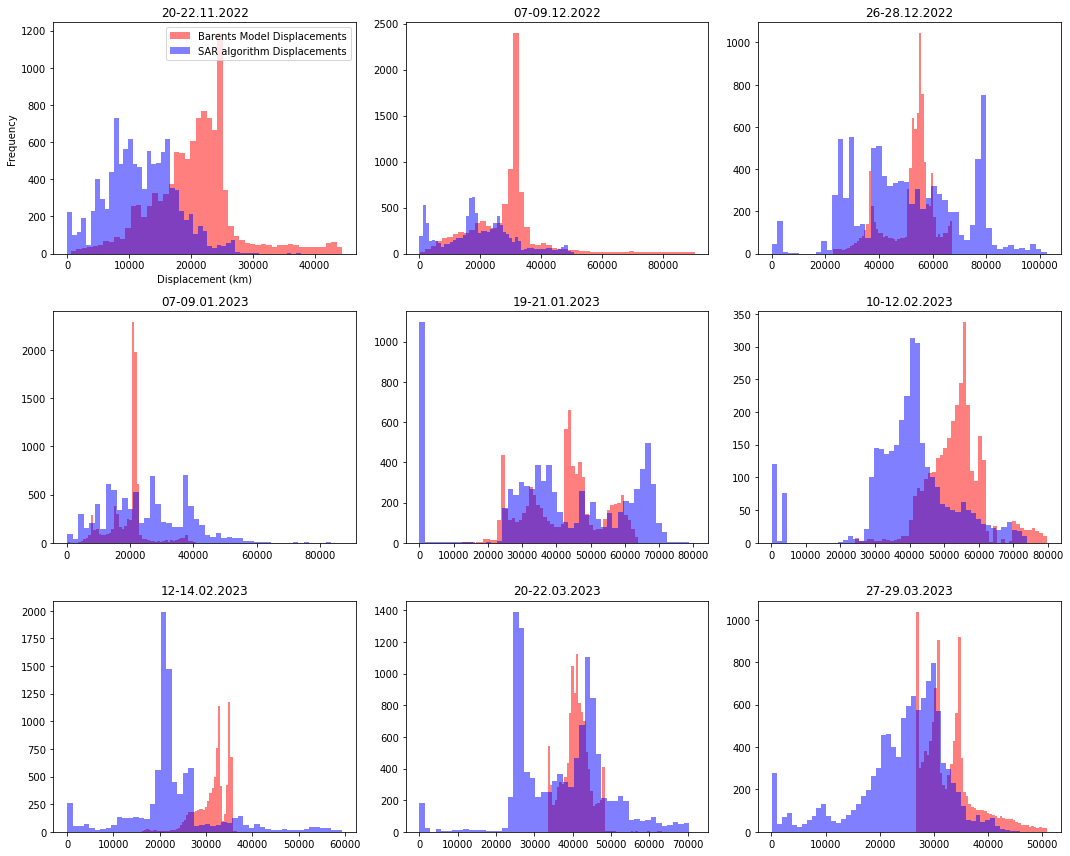

In [41]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()


    # Plot histograms
    ax.hist(disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
    ax.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])

    # Only add labels and legend to the first subplot for clarity
    if i == 0:
        ax.set_xlabel('Displacement (km)')
        ax.set_ylabel('Frequency')
        ax.legend()

# Adjust the layout
plt.tight_layout()


# Show the plot
plt.show()

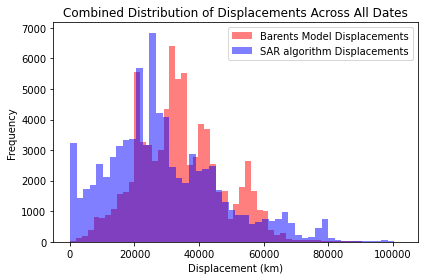

In [43]:
# Initialize a list to collect all displacements
all_disp_alg = []
all_disp_model_b = []

# Loop through all nine datasets
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()

    # Collect the displacements
    all_disp_alg.extend(disp_alg)
    all_disp_model_b.extend(disp_model_b)

# Plot the combined histograms
plt.hist(all_disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
plt.hist(all_disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

# Add labels and legend
plt.xlabel('Displacement (km)')
plt.ylabel('Frequency')
plt.title('Combined Distribution of Displacements Across All Dates')
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

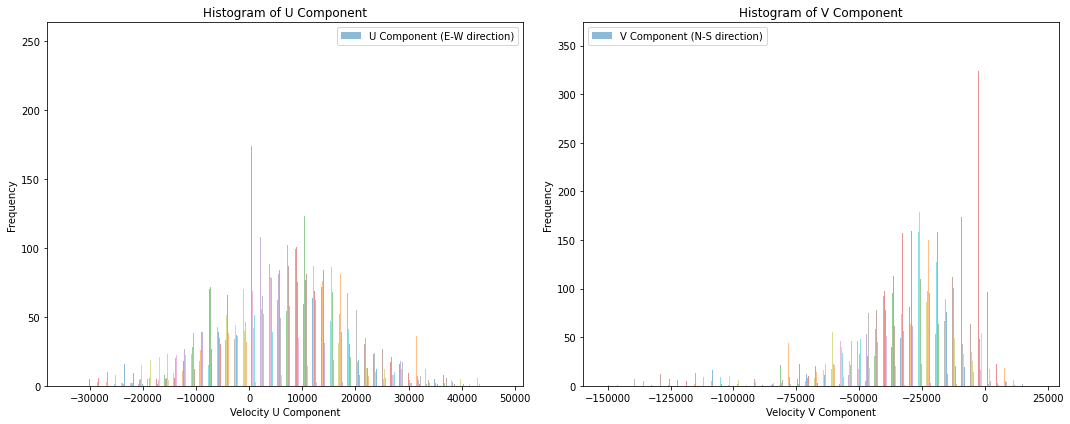

In [52]:
import matplotlib.pyplot as plt
import numpy as np


# Flatten the lists to get combined histograms for all datasets
u_all = np.concatenate(u_sar_list)
v_all = np.concatenate(v_sar_list)

# Plot histograms for u and v components
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(u_all, bins=50, alpha=0.5, label='U Component (E-W direction)')
plt.xlabel('Velocity U Component')
plt.ylabel('Frequency')
plt.title('Histogram of U Component')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(v_all, bins=50, alpha=0.5, label='V Component (N-S direction)')
plt.xlabel('Velocity V Component')
plt.ylabel('Frequency')
plt.title('Histogram of V Component')
plt.legend()

plt.tight_layout()
plt.show()


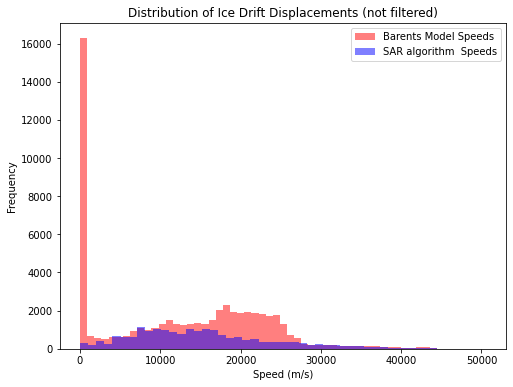

In [49]:
disp_model_b = np.sqrt(( model_u**2+ model_v**2)) 
disp_alg = np.sqrt((upm_list_no_inf**2+ vpm_list_no_inf**2))

disp_model_b = disp_model_b.flatten()
disp_alg = disp_alg.flatten()


plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(disp_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Speeds')

# Plotting Reference Speed
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Displacements (not filtered)')
plt.legend()
plt.show()



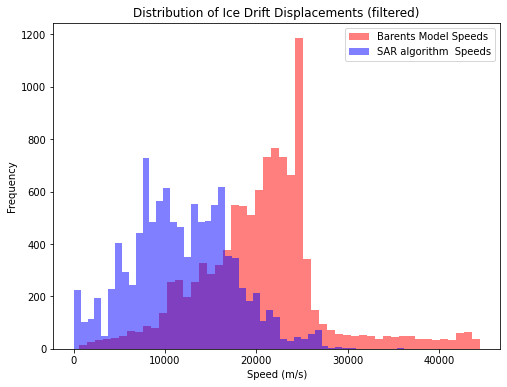

Reference Speeds:
Mean speed: 11.9 km
Min speed: 0.0 km
Max speed: 37.7 km
95th percentile speed: 21317.1675 km

Model Speeds:
Mean speed: 20.6 km
Min speed: 0.6 km
Max speed: 44.5 km
95th percentile speed: 33905.5220 km


In [56]:
disp_model_b = np.sqrt(( model_u**2+ model_v**2)) 
disp_alg = np.sqrt((upm_list_no_inf**2+ vpm_list_no_inf**2))

disp_model_b = disp_model_b[gpi2_list[0]].flatten()
disp_alg = disp_alg[gpi2_list[0]].flatten()

plt.figure(figsize=(8,6))

# Plotting Model displacements
plt.hist(disp_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Displacements')

# Plotting Reference displacement
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Displacements')

plt.xlabel('Displacement (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Displacements (filtered)')
plt.legend()

# Save plot
plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/drift_comparison_hist.png", dpi=300, bbox_inches='tight')


plt.show()


# Print statistics for reference displacements
percentile_95_ref = np.percentile(disp_alg, 95)
mean_disp_ref = np.nanmean(disp_alg)
min_disp_ref = np.nanmin(disp_alg)
max_disp_ref = np.nanmax(disp_alg)

print(f"Reference disp:")
print(f"Mean disp: {mean_disp_ref/1000:.1f} km")
print(f"Min disp: {min_disp_ref/1000:.1f} km")
print(f"Max disp: {max_disp_ref/1000:.1f} km")
print(f"95th percentile disp: {percentile_95_ref:.4f} km")

# Print statistics for model displacements
percentile_95_model = np.percentile(disp_model_b, 95)
mean_disp_model = np.nanmean(disp_model_b)
min_disp_model = np.nanmin(disp_model_b)
max_disp_model = np.nanmax(disp_model_b)

print("\nModel disp:")
print(f"Mean disp: {mean_disp_model/1000:.1f} km")
print(f"Min disp: {min_disp_model/1000:.1f} km")
print(f"Max disp: {max_disp_model/1000:.1f} km")
print(f"95th percentile disp: {percentile_95_model:.4f} km")
